In [154]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil
import glob
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision
from torchvision.transforms import v2
from skimage import color
import numpy as np
from copy import deepcopy
from matplotlib.pyplot import figure, imshow, axis
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch

In [24]:
data_path = Path.cwd() / 'data'
test_path = Path(data_path / "test")
train_path = Path(data_path / "train")
val_path = Path(data_path / "val")

for path in [test_path, train_path, val_path]:
    files = glob.glob(path.absolute().as_posix() + '/*')
    for f in files:
        os.remove(f)

original_data_path = data_path / 'landscape-pictures'
all_filenames = list(original_data_path.glob('*'))
train_val_filenames, test_filenames = train_test_split(all_filenames, test_size=1000, random_state=123)
train_filenames, val_filenames = train_test_split(train_val_filenames, test_size=500, random_state=123)

subdirectories = {
    test_path: test_filenames,
    val_path: val_filenames,
    train_path: train_filenames
}

def fill_sub_dir(sub_dir, file_subset):
    for file in file_subset:
        file_path = sub_dir / file.name
        shutil.copyfile(file, file_path)

for sub_dir, file_subset in subdirectories.items():
    fill_sub_dir(sub_dir, file_subset)

In [28]:
test_path, val_path, train_path = [path.absolute().as_posix() for path in list(subdirectories.keys())]

In [159]:
class ImageData(Dataset):
    def __init__(self, root, transform):
        """Constructor

        Args:
            root (Path/str): Filepath to the data root, e.g. './data/train'
            transform (Compose): A composition of image transforms, see below.
        """

        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")

        self.root = root
        self.transform = transform
        self.greyscale_transform = torchvision.transforms.v2.Grayscale

        self._samples = self._collect_samples()

    def __getitem__(self, index):
        """Get sample by index

        Args:
            index (int)

        Returns:
             The index'th sample (color, grayscale)
        """


        path = self._samples[index]
        original_img = Image.open(path)
        transformed_img = self.transform(original_img)

        img_array = np.asarray(transformed_img) / 255
        lab_img = color.rgb2lab(img_array)

        lab_img_gray = deepcopy(lab_img)
        lab_img_gray[:, :, 1:] = 0

        return lab_img, lab_img_gray

    def __len__(self):
        """Total number of samples"""
        return len(self._samples)

    def _collect_samples(self):
        """"
        Helper method for the constructor
        """

        paths = self._collect_imgs_sub_dir(self.root)
        # Sorting is not strictly necessary, but filesystem globbing (wildcard search) is not deterministic,
        # and consistency is nice when debugging.
        return sorted(paths)

    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        """Collect image paths in a directory

        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(
                f"Directory '{sub_dir}' does not exist. Are you sure you have the correct path?"
            )
        return sub_dir.glob("*.jpg")

In [160]:
image_size = 256

transform = v2.Compose([
    v2.Resize(image_size),
    v2.CenterCrop(image_size),
    v2.RandomHorizontalFlip(0.05)
])

train_dataset = ImageData(train_path, transform)
val_dataset = ImageData(val_path, transform)

46.42967986939652
-57.41204762763241


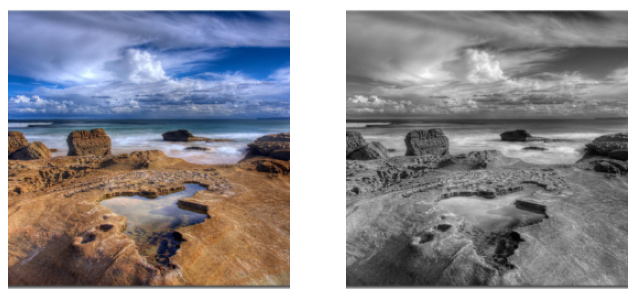

In [205]:
def show_sample(dataset: Dataset, index: int):
    lab_arr, lab_arr_gray = dataset[index]
    print(np.max(lab_arr[:, :, 1:].flatten()))
    print(np.min(lab_arr[:, :, 1:].flatten()))

    fig = figure(figsize=(10, 8), dpi=80)
    for i, arr in enumerate([lab_arr, lab_arr_gray]):
        rgb_arr = np.round(color.lab2rgb(arr) * 255)
        rgb_arr = rgb_arr.astype(np.uint8)
        img = Image.fromarray(rgb_arr)
        
        fig.add_subplot(1, 2, i + 1)
        imshow(img)
        axis('off')

show_sample(train_dataset, 8)

In [172]:
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [288]:
class LayerReLU(nn.Module):
      def __init__(self, layer: nn.Module):
         super().__init__()
         self.layer = layer

      def forward(self, x):
         x = self.layer(x)
         relu = nn.ReLU()
         return relu(x)

class Print(nn.Module):
    def __init__(self):
        super(Print, self).__init__()

    def forward(self, x):
        print(x.shape)
        return x

class BaseColorizer(nn.Module):
   def __init__(self):
      super().__init__()
      self.conv1 = LayerReLU(nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1))
      self.conv2 = LayerReLU(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1))
      self.conv3 = LayerReLU(nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1))
      self.conv4 = LayerReLU(nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1))
      self.conv5 = LayerReLU(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1))
      self.conv6 = LayerReLU(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1))
      self.conv7 = LayerReLU(nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1))
      self.conv8 = LayerReLU(nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1))
      self.conv9 = LayerReLU(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1))
      self.conv10 = LayerReLU(nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2))
      self.conv_transp = LayerReLU(nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1))
      self.conv11 = nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0)
      
      self.softmax = nn.Softmax(dim=1)
      self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
      self.upsample4 = nn.Upsample(scale_factor=8, mode='bilinear')

      self.seq = nn.Sequential(self.conv1,
                             self.conv2,
                             nn.BatchNorm2d(num_features=64),
                             self.conv3,
                             self.conv4,
                             nn.BatchNorm2d(num_features=128),
                             self.conv5,
                             self.conv6,
                             self.conv7,
                             nn.BatchNorm2d(num_features=256),
                             self.conv8,
                             self.conv9,
                             self.conv9,
                             nn.BatchNorm2d(num_features=512),
                             self.conv10,
                             self.conv10,
                             self.conv10,
                             nn.BatchNorm2d(num_features=512),
                             self.conv10,
                             self.conv10,
                             self.conv10,
                             nn.BatchNorm2d(num_features=512),
                             self.conv9,
                             self.conv9,
                             self.conv9,
                             nn.BatchNorm2d(num_features=512),
                             self.conv_transp,
                             self.conv6,
                             self.conv6,
                             self.conv11,
                             self.softmax,
                             self.model_out,
                             self.upsample4)
   
   def forward(self, input: np.ndarray):
      input_l = torch.tensor(input[:, :, :, 0:1] / 100, dtype=torch.float32)
      print(input_l.shape)
      
      output_ab = self.seq(input_l.permute(0, 3, 1, 2))
      output_ab_normalized = output_ab * 255 - 127
      print(output_ab_normalized.shape)
      return torch.cat((input_l * 100, output_ab_normalized.permute(0, 2, 3, 1)), 3)

base_model = BaseColorizer()

base_model.forward(np.array([train_dataset[8][0]]))

torch.Size([1, 256, 256, 1])
torch.Size([1, 2, 256, 256])


tensor([[[[  99.3336, -126.5501, -127.2800],
          [  99.3336, -126.5501, -127.2800],
          [  99.3336, -126.5501, -127.2800],
          ...,
          [  99.3336, -126.5485, -127.2764],
          [  99.3336, -126.5485, -127.2764],
          [  99.3336, -126.5485, -127.2764]],

         [[  99.5320, -126.5501, -127.2800],
          [  99.5320, -126.5501, -127.2800],
          [  99.5320, -126.5501, -127.2800],
          ...,
          [  99.5320, -126.5485, -127.2764],
          [  99.5320, -126.5485, -127.2764],
          [  99.5320, -126.5485, -127.2764]],

         [[  98.6181, -126.5501, -127.2800],
          [  98.5932, -126.5501, -127.2800],
          [  98.6670, -126.5501, -127.2800],
          ...,
          [  98.5932, -126.5485, -127.2764],
          [  98.5932, -126.5485, -127.2764],
          [  98.8409, -126.5485, -127.2764]],

         ...,

         [[  36.6870, -126.5477, -127.2786],
          [  36.3881, -126.5477, -127.2786],
          [  36.3573, -126.5477, -

In [ ]:
a = np.arange(27).reshape(3, 3, 3)
a, a[:, :, 0:1]